# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [ ]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [ ]:
from sklearn.model_selection import train_test_split

df_1 = df.loc[:, df.columns != 'salary'] # Из-за этого столбца может быть лик, так как тут тоже зп

y = df_1['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(df_1, y, test_size = 0.1, random_state=52)
X_train_train, X_validation, y_train_train, y_validation = train_test_split(X_train, y_train, test_size=1/9, random_state=52)

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import numpy as np


categorical_features = ['experience_level', 'employment_type',
                        'job_title', 'salary_currency', 'employee_residence',
                        'company_location', 'company_size']


ohe = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(X_train_train[categorical_features])
X_train_train_ohe = ohe.transform(X_train_train[categorical_features])
X_train_train_ohe = pd.DataFrame(X_train_train_ohe, columns = ohe.get_feature_names_out())
X_train_full = pd.concat([X_train_train_ohe, X_train_train[['work_year', 'remote_ratio']].reset_index()], axis=1)

X_validation_ohe = ohe.transform(X_validation[categorical_features])
X_validation_ohe = pd.DataFrame(X_validation_ohe, columns=ohe.get_feature_names_out())
X_validation_full = pd.concat([X_validation_ohe, X_validation[['work_year', 'remote_ratio']].reset_index()], axis=1)

X_test_ohe = ohe.transform(X_test[categorical_features])
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names_out())
X_test_full = pd.concat([X_test_ohe, X_test[['work_year', 'remote_ratio']].reset_index()], axis=1)


lr = LinearRegression().fit(X_train_full, y_train_train)

y_pred = lr.predict(X_test_full)

print(f"MAPE {mean_absolute_percentage_error(y_test, y_pred)}")
print(f"RMSE {np.sqrt(mean_squared_error(y_test, y_pred))}")

MAPE 859782.6534312945
RMSE 278299905874.2748


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
from xgboost.sklearn import XGBRegressor

params = {
    'max_depth' : [2,3,5,7],
    'learning_rate' : [0.01, 0.05, 0.1, 0.2] ,
    'n_estimators' : list(range(1, 15, 3)) ,
    'gamma' : [0.01, 0.05, 0.1, 0.5, 1, 3, 10],
    'sub_sample' : [0.2, 0.4, 0.6,1]
}

from sklearn.model_selection import GridSearchCV

model_xgb = XGBRegressor(seed=52)

grid_search = GridSearchCV(estimator=model_xgb, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_validation_full, y_validation)
grid_search.best_params_, grid_search.best_score_

({'gamma': 0.01,
  'learning_rate': 0.2,
  'max_depth': 3,
  'n_estimators': 13,
  'sub_sample': 0.2},
 -2117835412.7811184)

Тут я не взял много деревьев и других гиепрпараметров, так как там нахождение параметров занимало больше 30 минут(((

In [ ]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
model_xgb = XGBRegressor(learning_rate=0.2, gamma=0.01, max_depth=3, n_estimators=13, sub_sample=0.2, seed=52)

xgb = model_xgb.fit(X_train_full, y_train_train)
preds = xgb.predict(X_test_full)

print(f"MAPE {mean_absolute_percentage_error(y_test, preds)}")
print(f"RMSE {np.sqrt(mean_squared_error(y_test, preds))}")

MAPE 0.36833847517533597
RMSE 51383.36688383426


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 10.6 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor
params = {
    'depth' : [2,3,4,6,8,12] ,
    'learning_rate' : [0.01, 0.05, 0.1, 0.2] ,
    'iterations' : list(range(50, 151, 50)),
    'loss_function': ['RMSE'],
}
model_ctb = CatBoostRegressor(random_seed=52)
grid_search_cb = GridSearchCV(estimator=model_ctb, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search_cb.fit(X_validation_full, y_validation)
grid_search_cb.best_params_, grid_search_cb.best_score_

0:	learn: 59036.5981394	total: 47ms	remaining: 4.65s
1:	learn: 57567.8591917	total: 49.1ms	remaining: 2.41s
2:	learn: 56266.1777674	total: 50ms	remaining: 1.62s
3:	learn: 54948.0147522	total: 50.7ms	remaining: 1.22s
4:	learn: 54051.0091243	total: 51.3ms	remaining: 975ms
5:	learn: 53221.2741247	total: 52.1ms	remaining: 815ms
6:	learn: 52307.4369171	total: 52.7ms	remaining: 700ms
7:	learn: 51487.3048692	total: 53.3ms	remaining: 613ms
8:	learn: 50978.8650793	total: 53.9ms	remaining: 545ms
9:	learn: 50298.9696371	total: 54.7ms	remaining: 492ms
10:	learn: 49753.5394341	total: 55.4ms	remaining: 448ms
11:	learn: 49297.7835894	total: 56.1ms	remaining: 411ms
12:	learn: 48809.0169181	total: 56.7ms	remaining: 380ms
13:	learn: 48452.6133998	total: 57.4ms	remaining: 352ms
14:	learn: 48173.3792909	total: 58ms	remaining: 329ms
15:	learn: 47827.6897525	total: 58.7ms	remaining: 308ms
16:	learn: 47357.9068311	total: 59.3ms	remaining: 290ms
17:	learn: 47012.5818884	total: 60ms	remaining: 273ms
18:	learn:

({'depth': 3,
  'iterations': 100,
  'learning_rate': 0.1,
  'loss_function': 'RMSE'},
 -2037904991.7783425)

In [ ]:
from catboost import CatBoostRegressor
ctb = CatBoostRegressor(
    depth = 3,
    learning_rate=0.1,
    iterations = 100,
    loss_function = 'RMSE',
    random_seed=52
)

ctb.fit(X_train_full, y_train_train)
y_pred = ctb.predict(X_test_full)
print(f"MAPE {mean_absolute_percentage_error(y_test, y_pred)}")
print(f"RMSE {np.sqrt(mean_squared_error(y_test, y_pred))}")

0:	learn: 61276.9725839	total: 1.87ms	remaining: 185ms
1:	learn: 59894.8634486	total: 5.63ms	remaining: 276ms
2:	learn: 58587.2707598	total: 7.98ms	remaining: 258ms
3:	learn: 57424.9840091	total: 10.6ms	remaining: 255ms
4:	learn: 56519.7498091	total: 12.9ms	remaining: 245ms
5:	learn: 55543.2425259	total: 15.3ms	remaining: 240ms
6:	learn: 54881.8752850	total: 20.3ms	remaining: 269ms
7:	learn: 54147.3151268	total: 22.5ms	remaining: 259ms
8:	learn: 53620.2783815	total: 27.3ms	remaining: 276ms
9:	learn: 53031.6656378	total: 28.9ms	remaining: 260ms
10:	learn: 52602.5579174	total: 32.2ms	remaining: 260ms
11:	learn: 52249.5042321	total: 36.9ms	remaining: 271ms
12:	learn: 51895.4519681	total: 39.3ms	remaining: 263ms
13:	learn: 51664.8978524	total: 44.3ms	remaining: 272ms
14:	learn: 51454.3991117	total: 45.6ms	remaining: 258ms
15:	learn: 51280.9471469	total: 50.6ms	remaining: 266ms
16:	learn: 51035.5786069	total: 53.6ms	remaining: 262ms
17:	learn: 50893.2589132	total: 58.8ms	remaining: 268ms
18

Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [ ]:
from catboost import Pool
pool_train = Pool(data=X_train_train, label=y_train_train, cat_features=categorical_features)
pool_valid = Pool(data=X_validation, label=y_validation, cat_features=categorical_features)
pool_test = Pool(data=X_test, label=y_test, cat_features=categorical_features)

In [ ]:
params = {
    'depth' : [2,3,4,6,8,12],
    'learning_rate' : [0.01, 0.05, 0.1, 0.2],
    'iterations' : list(range(50, 151, 50)),
    'loss_function': ['RMSE'],
}

ctb = CatBoostRegressor(random_seed=52)

grid_search_cb_pool = GridSearchCV(estimator=ctb, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search_cb_pool.fit(X_validation, y_validation, cat_features = categorical_features)
grid_search_cb_pool.best_params_, grid_search_cb_pool.best_score_

0:	learn: 56682.8715208	total: 698us	remaining: 104ms
1:	learn: 53394.3614784	total: 2.05ms	remaining: 152ms
2:	learn: 49627.5286671	total: 3.23ms	remaining: 158ms
3:	learn: 46907.2296905	total: 4.12ms	remaining: 150ms
4:	learn: 43319.4960096	total: 4.89ms	remaining: 142ms
5:	learn: 40374.7354243	total: 5.61ms	remaining: 135ms
6:	learn: 38281.6836882	total: 6.3ms	remaining: 129ms
7:	learn: 35459.2571721	total: 7.01ms	remaining: 124ms
8:	learn: 32905.2127214	total: 7.75ms	remaining: 121ms
9:	learn: 31315.8433372	total: 8.55ms	remaining: 120ms
10:	learn: 29090.1241275	total: 9.58ms	remaining: 121ms
11:	learn: 27121.7991009	total: 10.3ms	remaining: 118ms
12:	learn: 25251.5039600	total: 11.2ms	remaining: 118ms
13:	learn: 23776.1986184	total: 11.9ms	remaining: 116ms
14:	learn: 22364.3144446	total: 12.6ms	remaining: 114ms
15:	learn: 20969.7404348	total: 13.3ms	remaining: 111ms
16:	learn: 19635.5788561	total: 14ms	remaining: 110ms
17:	learn: 18452.4978313	total: 14.8ms	remaining: 109ms
18:	le

({'depth': 2,
  'iterations': 150,
  'learning_rate': 0.1,
  'loss_function': 'RMSE'},
 -18095275.81857862)

In [ ]:
ctb_pool = CatBoostRegressor(depth=3, iterations=150, learning_rate = 0.1, random_seed=52)
ctb_pool.fit(pool_train)
y_pred_pool = ctb_pool.predict(pool_test)
print(f"MAPE {mean_absolute_percentage_error(y_test, y_pred_pool)}")
print(f"RMSE {np.sqrt(mean_squared_error(y_test, y_pred_pool))}")

0:	learn: 57692.5633546	total: 6.38ms	remaining: 951ms
1:	learn: 52782.1296556	total: 9.71ms	remaining: 718ms
2:	learn: 48412.3939887	total: 13.6ms	remaining: 667ms
3:	learn: 44510.9404729	total: 17.6ms	remaining: 641ms
4:	learn: 40768.7133534	total: 22.7ms	remaining: 659ms
5:	learn: 37406.1703205	total: 26.8ms	remaining: 643ms
6:	learn: 34467.9323207	total: 30.9ms	remaining: 631ms
7:	learn: 31732.6962200	total: 34.7ms	remaining: 615ms
8:	learn: 29256.3233727	total: 38.6ms	remaining: 605ms
9:	learn: 26932.0324371	total: 42.5ms	remaining: 594ms
10:	learn: 24889.8943063	total: 45.7ms	remaining: 577ms
11:	learn: 22980.0900638	total: 48.8ms	remaining: 561ms
12:	learn: 21328.3868656	total: 53.5ms	remaining: 564ms
13:	learn: 19725.0736773	total: 58.4ms	remaining: 568ms
14:	learn: 18323.4247790	total: 62.3ms	remaining: 561ms
15:	learn: 16982.8055488	total: 66.9ms	remaining: 560ms
16:	learn: 15796.1365360	total: 70.5ms	remaining: 551ms
17:	learn: 14713.1945786	total: 74.7ms	remaining: 548ms
18

**Ответ:** С помощью pool обучается быстрее и результат подозрительно лучше...


## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
from lightgbm import LGBMRegressor


params = {
    'max_depth' :  [2,3,4,6,8,12],
    'learning_rate' : [0.01, 0.05, 0.1, 0.2] ,
    'n_estimators' : list(range(50, 151, 50)) ,
}

model_lgbm = LGBMRegressor(random_state=52)

grid_search = GridSearchCV(estimator=model_lgbm, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_validation_full, y_validation)
grid_search.best_params_, grid_search.best_score_

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 160
[LightGBM] [Info] Number of data points in the train set: 376, number of used features: 16
[LightGBM] [Info] Start training from score 137789.061170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

({'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50},
 -2144939918.5951023)

In [ ]:
lgbm = LGBMRegressor(learning_rate=0.1, max_depth=2, n_estimators=50,random_state=52)
lgbm.fit(X_train_full, y_train_train)

y_pred = lgbm.predict(X_test_full)

print(f"MAPE {mean_absolute_percentage_error(y_test, y_pred)}")
print(f"RMSE {np.sqrt(mean_squared_error(y_test, y_pred))}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 341
[LightGBM] [Info] Number of data points in the train set: 3003, number of used features: 42
[LightGBM] [Info] Start training from score 136624.810523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
MAPE 0.35825452203837804
RMSE 51486.85177052694


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

**Ответ:** Если сравнивать библиотеки между собой, то по качетсву лучше всех катбуст с пулом, но в скорости уступает лайтгбм, потом лучший результат имеет обычный катбуст, xgboost и в конце лайтгбм. Но по скороси поиска гиперпараметров худще всех справился xgboost, а лучше всех лайтгбм. Гиперпараметры у всех +- одинаковые кроме тех мест, где они искались долго (например для xgboost я меньше гиперпараметров взял, так как они долго искались).

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [ ]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [ ]:
import numpy as np

In [ ]:
df = ratings.T
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,6.0,7.0,8.000000,9.000000,...,4990.000000,4991.0,4992.000000,4993.000000,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.000000
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

In [ ]:
df_new = df.iloc[1:,:]
df_new.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [ ]:
df_new.fillna(0, inplace=True)
df_new.sample()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
morphine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
np.sum(df_new.isna().sum())

0

## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

In [ ]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters = 5, random_state=52)
k_means = k_means.fit(df_new)
clusters = k_means.predict(df_new)

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [ ]:
np.random.seed(52)
dicti = {}
clus = list(set(clusters))
for i in range(len(clus)):
  for j in clusters:
    if i == j and j not in dicti:
      dicti[i] = 1
    elif i == j and j in dicti:
      dicti[i] += 1

dicti

{0: 6, 1: 991, 2: 1, 3: 1, 4: 1}

**Ответ:** Почти все объекты были отнесены к 1 кластеру, это может быть связано с тем, что мы взяли мало кластеров, либо не нормализовали данные.

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [ ]:
for i in range(5):
  if list(clusters).count(i) == 1:
    index = np.where(clusters == i)
    for j in index[0]:
      print(df_new.iloc[j].name)

the beatles
the misfits
queen


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [ ]:
mean_time = np.mean(df_new, axis=1)

max_mean_arg = np.argmax(mean_time)

name_of_max_mean = df_new.iloc[max_mean_arg].name #Исполнитель, которого чаще всего слушают
name_of_max_mean

'the beatles'

**Ответ:** Beatles выделяется, так как он имеет больше всего прослушивание.

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [ ]:
from sklearn.preprocessing import normalize

df_norm = normalize(df_new)
df_norm = pd.DataFrame(df_norm, index = df_new.index, columns = df_new.columns)
df_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,0.000000,0.000000,0.000000,0.0,0.012054,0.000000,0.0,0.0,0.025864,0.004880,...,0.000000,0.0,0.033554,0.010569,0.002199,0.004952,0.0,0.021302,0.0,0.000000
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,0.0,0.0,0.000000,0.008771,...,0.008120,0.0,0.000000,0.000000,0.005122,0.000000,0.0,0.000000,0.0,0.000000
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,0.0,0.0,0.000000,0.009391,...,0.085361,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.019622
coldplay,0.000000,0.000000,0.000000,0.0,0.011129,0.000000,0.0,0.0,0.000000,0.000000,...,0.144628,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
modest mouse,0.000000,0.000000,0.000000,0.0,0.010260,0.000000,0.0,0.0,0.000000,0.019597,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

In [ ]:
km = KMeans(n_clusters = 5, random_state=52)
km.fit(df_norm)
clusters = km.predict(df_norm)

dicti = {}
clus = list(set(clusters))
for i in range(len(clus)):
  for j in clusters:
    if i == j and j not in dicti:
      dicti[i] = 1
    elif i == j and j in dicti:
      dicti[i] += 1

dicti

{0: 431, 1: 61, 2: 125, 3: 271, 4: 112}

**Ответ** Теперь кластеризация больше похожа на правду, так как в кластерах нет только 1 элемента;)

## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [ ]:
from scipy.spatial.distance import cosine


centroids = km.cluster_centers_

df_centroids = pd.DataFrame(centroids, columns=df_norm.columns)

dicti = {}

for i in range(len(centroids)):
    dist = df_norm.apply(lambda row: cosine(row, centroids[i]), axis=1)
    close_art = dist.nsmallest(10).index
    dicti[i] = close_art.tolist()

print('Top 10 closest artists in each cluster')

for i, art in dicti.items():
  print(f'Cluster {i+1}')
  print(', '.join(art))

Top 10 closest artists
Cluster 1
the beatles, the rolling stones, led zeppelin., pink fluid, radiohead, the clash, acdc, metallica, dylan. bob, red hot clili peppers
Cluster 2
nas, jay-z, a tribe called quest, kanye west, the roots featuring d'angelo, lupe the gorilla, gangstarr, mos def, little brother, murs and 9th wonder
Cluster 3
kelly clarkson, rihanna & jay-z, john mayer, maroon5, the pussycat dolls, alicia keys, mariah carey, jason mraz, beyoncé, justin timberlake
Cluster 4
radiohead, the arcade fire, broken social scene, sufjan stevens, animal collective, belle and sebastian, the shins, deathcab for cutie, of montreal, beirut
Cluster 5
fall out boy, taking back sunday, saosin, the used, cartel, blink-182, paramore, brand new, all time low, new found glory


**Ответ:** Классы определенно имеют смысл, так как теперь артисты были разделены по жанрам.

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

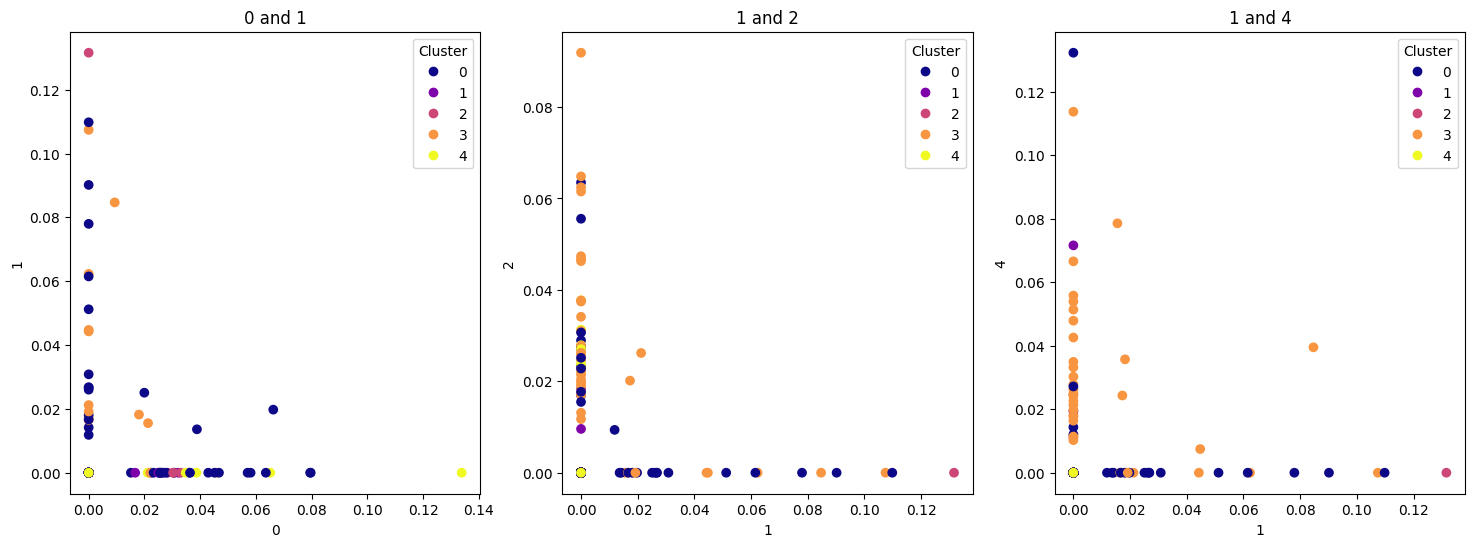

In [ ]:
import matplotlib.pyplot as plt

df_norm['Cluster'] = clusters

users_pair = [(0, 1), (1, 2), (1, 4)]


fig, axes = plt.subplots(1, len(users_pair), figsize=(15, 6))

for i, (user1, user2) in enumerate(users_pair):
    ax = axes[i]
    scatter = ax.scatter(df_norm[user1], df_norm[user2], c=df_norm['Cluster'], cmap='plasma')
    ax.set_xlabel(user1)
    ax.set_ylabel(user2)
    ax.set_title(f'{user1} and {user2}')
    ax.legend(*scatter.legend_elements(), title="Cluster")

plt.show()

**Ответ:** Визуализация имеет посредственное качетсво, так как kmeans ищет закономерности, которые четки расделены, а тут разделения пересекаются/имеют прямоугольную форму.

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

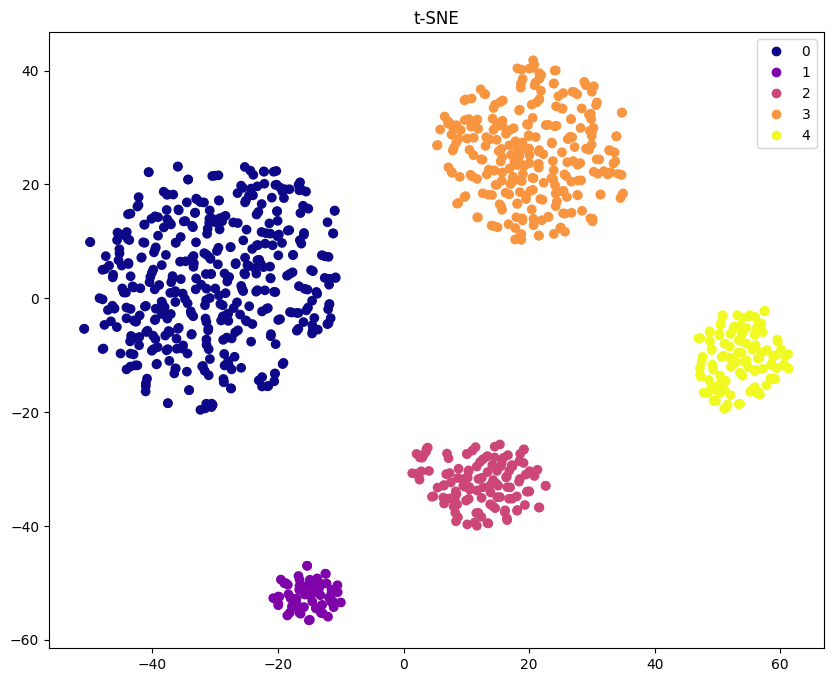

In [ ]:
from sklearn.manifold import TSNE

df_norm.columns = df_norm.columns.astype(str)

tsne = TSNE(n_components=2, random_state=152)
tsne_results = tsne.fit_transform(df_norm)

tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = clusters

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['Cluster'], cmap='plasma')
plt.legend(*scatter.legend_elements())
plt.title('t-SNE')
plt.show()